## Imports

In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import matplotlib.pyplot as plt # this is used for the plot the graph
import imageio.v3 as iio # this is used for image operation
import pydicom as dicom # for medical image analysis
import cv2 # for image processing
from PIL import Image # for image processing
import os # for path manipulation
import dicom2jpg # for converting dicom to jpg
import seaborn as sns # for data visualization
from pathlib import Path # for path manipulation
from sklearn import svm # for machine learning
from sklearn.model_selection import train_test_split # for splitting data into train and test
import torch
import torch.nn as nn
from skimage.transform import resize
import threading
from joblib import dump, load
import cv2

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import sklearn
from sklearn import metrics
from yellowbrick.classifier import confusion_matrix
from yellowbrick.classifier import classification_report
import seaborn as sn
from pretty_confusion_matrix import pp_matrix

sns.set_style("darkgrid")
sns.set_color_codes("pastel")

## Preprocessing

Divisão entre as classes 60% 0 e 40% 1 (Somando cerca de 5000 dados)

In [3]:
df1 = pd.read_csv("data/train.csv")
df1_1 = df1[df1["cancer"] == 1]
df1_0 = df1[df1["cancer"] == 0]
_, df1_0 = train_test_split(df1_0, test_size=0.05, random_state=47)

In [4]:
df2 = pd.read_csv("../archive/csv/calc_case_description_train_set.csv")
df2["pathology"] = df2["pathology"].apply(lambda x: int(x == 'MALIGNANT'))
df2_1 = df2[df2["pathology"] == 1]
folders2 = df2_1["image file path"].apply(lambda x: "../archive/jpeg/" + x.split("/")[-2])
files = []
for folder in folders2:
    for file in os.listdir(folder):
        files.append(folder+"/"+file)

In [5]:
os.listdir(folders2[0])

['1-188.jpg']

In [6]:
files_0 = [str(df1_0.iloc[x]['patient_id']) + '/' + str(df1_0.iloc[x]['image_id']) + '.dcm' for x in range(len(df1_0))]

In [7]:
files_1 = [str(df1_1.iloc[x]['patient_id']) + '/' + str(df1_1.iloc[x]['image_id']) + '.dcm' for x in range(len(df1_1))]

In [8]:
files_1.extend(files)

In [9]:
_path = Path("../train_images/")

In [10]:
# Pegando a primeira imagem como exemplo (640805896.dcm)
example = _path.__str__() + "/" + files_1[0]
dicom.dcmread(example)

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.10009.1.2.3.10130.1.388811999
(0002, 0010) Transfer Syntax UID                 UI: JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])
(0002, 0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.2.12.0
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.840.10009.1.2.3.10130.1.388811999
(0008, 0023) Content Date                        DA: '20221118'
(0008, 0033) Content Time                        TM: '183942.402329'
(0010, 0020) Patient ID                          LO: '10130'
(0018, 11a0) Body Part Thickness                 DS: '73.0'
(001

In [11]:
def gerarDivs(size, list_of_files):
    listDivs = []
    for i in range(0, len(list_of_files)+1, size):
        listDivs.append(list_of_files[i:i+(size)])
    return listDivs

In [12]:
def open_files(list_of_files, images_array, erros, index_start):
    print(f"> {index_start} Start thread")
    for i, image in enumerate(list_of_files):
        try:
            image_path = _path.__str__() + '/' + image
            try:
                ds = dicom.dcmread(image_path)
                ds.decompress('gdcm')
                image_as_np = ds.pixel_array.astype(np.float32)
            except:
                img = Image.open( image_path )
                img.load()
                image_as_np = np.asarray( img, dtype="int32" )

            image_as_np = resize(image_as_np, (204, 166), anti_aliasing=True)

            images_array[index_start+i] = image_as_np
        except Exception as e:
            print("\nError:", image)
            erros += 1
            raise e
    print(f"> [index_start] End thread")

In [13]:
images_array_0 = [np.zeros((204, 166))]*len(files_0)
erros = 0

open_files(files_0,
            images_array_0,
            erros,
            0)

dump(images_array_0, r"./images_array_0.hdf5")
del images_array_0


> 0 Start thread
> [index_start] End thread


In [14]:
images_array_1 = [np.zeros((204, 166))]*len(files_1)
erros_test = 0

open_files(files_1,
            images_array_1,
            erros_test,
            0)

dump(images_array_1, r"./images_array_1.hdf5")
del images_array_1

> 0 Start thread
> [index_start] End thread


## Load Data

80% dos dados para treino e 20% para teste

In [2]:
X_0 = load(r"./images_array_0.hdf5")
X_1 = load(r"./images_array_1.hdf5")
y = [0]*len(X_0) + [1]*len(X_1)

X = np.array(X_0+X_1)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)
#X_train, X_train_2, y_train, y_train_2 = train_test_split(X_train, y_train, test_size=0.5, random_state=47)

---

## LSTM

Acurácia - 67,46

| Accuracy  | 67,46 |
|-----------|-------|
| Precision | 59,07 |
| Recall    | 49,40 |
| F1        | 53,80 |

Matriz de Confusão
|   | 0   | 1   |
|---|-----|-----|
| 0 | 425 | 115 |
| 1 | 170 | 166 |

<br>
<img src="ROC_LSTM.png">

---

---

### Model

In [1]:
device = 'cpu'

In [5]:
# Definir a classe do modelo LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out[:, -1, :])
        return out
        
    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device),
                torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device))


In [7]:
# Definir os parâmetros do modelo
input_size = 166
hidden_size = 128
output_size = 1
num_layers = 5

# Criar uma instância do modelo
model = LSTMModel(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [6]:
X_train = torch.from_numpy(np.array(X_train)).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)

In [7]:
# Definir o número de épocas de treinamento
num_epochs = 500

# Treinar o modelo
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs.squeeze(), y_train)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Printar informações de treinamento
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/500], Loss: 0.6866
Epoch [20/500], Loss: 0.6803
Epoch [30/500], Loss: 0.6700
Epoch [40/500], Loss: 0.6485
Epoch [50/500], Loss: 0.6395
Epoch [60/500], Loss: 0.6289
Epoch [70/500], Loss: 0.6184
Epoch [80/500], Loss: 0.6068
Epoch [90/500], Loss: 0.5918
Epoch [100/500], Loss: 0.5718
Epoch [110/500], Loss: 0.5416
Epoch [120/500], Loss: 0.4869
Epoch [130/500], Loss: 0.4308
Epoch [140/500], Loss: 0.3840
Epoch [150/500], Loss: 0.3481
Epoch [160/500], Loss: 0.3109
Epoch [170/500], Loss: 0.2865
Epoch [180/500], Loss: 0.2907
Epoch [190/500], Loss: 0.2785
Epoch [200/500], Loss: 0.2685
Epoch [210/500], Loss: 0.2614
Epoch [220/500], Loss: 0.2516
Epoch [230/500], Loss: 0.2456
Epoch [240/500], Loss: 0.2410
Epoch [250/500], Loss: 0.2380
Epoch [260/500], Loss: 0.2405
Epoch [270/500], Loss: 0.3147
Epoch [280/500], Loss: 0.2724
Epoch [290/500], Loss: 0.2621
Epoch [300/500], Loss: 0.2540
Epoch [310/500], Loss: 0.2583
Epoch [320/500], Loss: 0.2507
Epoch [330/500], Loss: 0.2478
Epoch [340/500], Lo

In [8]:
torch.save(model.state_dict(), "./LSTM_v2.hdf5")

### Metrics

In [26]:
model.load_state_dict(torch.load("./LSTM_v2.hdf5"))
model.eval()

LSTMModel(
  (lstm): LSTM(166, 128, num_layers=5, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [27]:
X_test = torch.from_numpy(np.array(X_test)).float().to(device)

In [29]:
# Testar o modelo
with torch.no_grad():
    model.eval()
    y_pred = model(X_test)
    y_score = torch.softmax(y_pred, dim=1)
y_pred = list(map(int, (np.array(y_pred) > 0.5)))

In [30]:
metrics.accuracy_score(y_test, y_pred)

0.6746575342465754

In [31]:
metrics.confusion_matrix(y_test, y_pred)

array([[425, 115],
       [170, 166]])

In [32]:
metrics.precision_score(y_test, y_pred)

0.5907473309608541

In [33]:
metrics.recall_score(y_test, y_pred)

0.49404761904761907

In [34]:
metrics.f1_score(y_test, y_pred)

0.5380875202593193

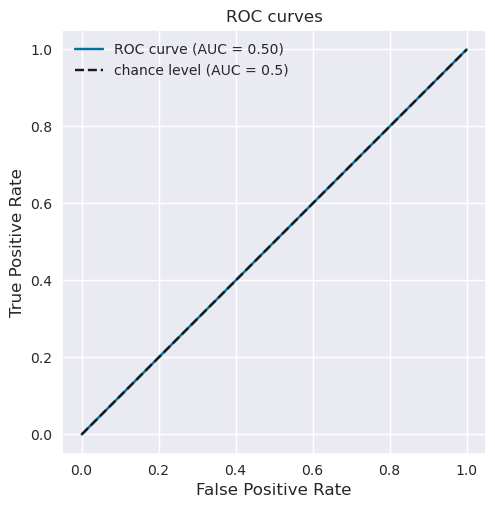

In [35]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score)
auc = metrics.roc_auc_score(y_test, y_score)

plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend()
plt.show()

---

## SVM 

Modelo com melhor acurácia e melhor tempo de execução

| Accuracy  |  74,20 |
|-----------|--------|
| Precision | 100,00 |
| Recall    |  32,73 |
| F1        |  49,32 |

Matriz de Confusão
|   | 0   | 1   |
|---|-----|-----|
| 0 | 540 |  0  |
| 1 | 220 | 110 |

<br>
<img src="ROC_SVM.png">

---

#### Testing

In [3]:
svm_model = svm.SVC()

In [4]:
svm_model.fit(X_train.reshape(len(X_train), -1), y_train)

SVC()

In [5]:
dump(svm_model, r"./svm_rbf_model.hdf5")

['./svm_rbf_model.hdf5']

In [115]:
svm_model = load(r"./svm_rbf_model.hdf5")

In [116]:
y_pred = svm_model.predict(X_test.reshape(len(X_test), -1))

In [117]:
metrics.accuracy_score(y_test, y_pred)

0.7420091324200914

In [118]:
metrics.confusion_matrix(y_test, y_pred)

array([[540,   0],
       [226, 110]])

In [119]:
metrics.precision_score(y_test, y_pred)

1.0

In [120]:
metrics.recall_score(y_test, y_pred)

0.3273809523809524

In [121]:
metrics.f1_score(y_test, y_pred)

0.4932735426008969

In [122]:
y_score = svm_model.decision_function(X_test.reshape(len(X_test), -1))

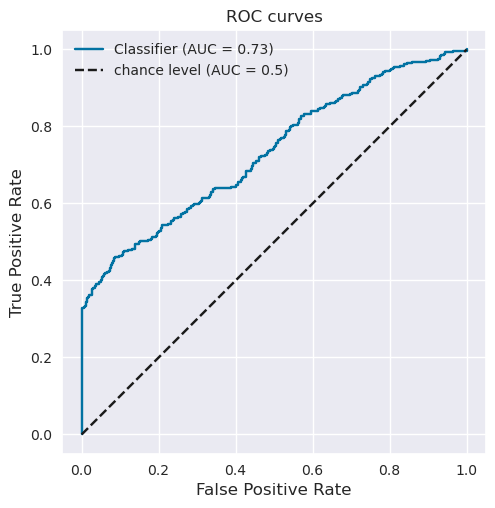

In [123]:
metrics.RocCurveDisplay.from_predictions(
    y_test,
    y_score,
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend()
plt.show()

#### Grid Search

In [23]:
svm_model = svm.SVC()

parameters = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]

clf = GridSearchCV(svm_model, parameters)

In [24]:
clf.fit(X_train.reshape(len(X_train), -1), y_train)

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}])

In [26]:
clf.best_score_

0.7340195638883229

In [27]:
clf.best_estimator_

SVC(C=1, gamma=0.001)

In [28]:
svm_model = svm.SVC()

parameters = [
  {'C': [1, 10, 100, 1000], 'gamma': ['scale'], 'kernel': ['rbf']},
 ]

clf = GridSearchCV(svm_model, parameters)

In [29]:
clf.fit(X_train.reshape(len(X_train), -1), y_train)

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': ['scale'],
                          'kernel': ['rbf']}])

In [30]:
clf.best_score_

0.7337342571836152

In [31]:
clf.best_estimator_

SVC(C=1)

In [32]:
svm_model = svm.NuSVC()

parameters = [
  {'nu': [0.1, 0.5, 0.8, 1], 'kernel': ['linear']},
  {'nu': [0.1, 0.5, 0.8, 1], 'gamma': [0.001, 0.0001, 'scale', 'auto'], 'kernel': ['rbf']},
]

clf = GridSearchCV(svm_model, parameters)

In [33]:
clf.fit(X_train.reshape(len(X_train), -1), y_train)

/home/gabriel/anaconda3/envs/mineracao/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/home/gabriel/anaconda3/envs/mineracao/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/gabriel/anaconda3/envs/mineracao/lib/python3.8/site-packages/sklearn/svm/_base.py", line 252, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "/home/gabriel/anaconda3/envs/mineracao/lib/python3.8/site-packages/skl

GridSearchCV(estimator=NuSVC(),
             param_grid=[{'kernel': ['linear'], 'nu': [0.1, 0.5, 0.8, 1]},
                         {'gamma': [0.001, 0.0001, 'scale', 'auto'],
                          'kernel': ['rbf'], 'nu': [0.1, 0.5, 0.8, 1]}])

In [34]:
clf.best_score_

0.7340195638883229

In [35]:
clf.best_estimator_

NuSVC(gamma=0.001, nu=0.1)

In [38]:
import scipy

In [43]:
from sklearn.utils.fixes import loguniform

In [50]:
svm_model = svm.SVC()

parameters = {
  'C': loguniform(1e0, 1e3),
  'gamma': loguniform(1e-4, 1e-3),
  'kernel': ['rbf'],
  'class_weight':['balanced', None]}

clf = RandomizedSearchCV(svm_model, parameters)

In [51]:
clf.fit(X_train.reshape(len(X_train), -1), y_train)

RandomizedSearchCV(estimator=SVC(),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f33a58d67f0>,
                                        'class_weight': ['balanced', None],
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f33a5938370>,
                                        'kernel': ['rbf']})

In [52]:
clf.best_score_

0.7340195638883229

In [53]:
clf.best_estimator_

SVC(C=56.09238413314149, gamma=0.0003730618425655635)

# CNN

Acurácia - 57,53

Matriz de Confusão
|   | 0   | 1   |
|---|-----|-----|
| 0 | 280 | 260 |
| 1 | 112 | 224 |

---


In [23]:
# Definir a classe do modelo CNN
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 102 * 83, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.unsqueeze(x, 1)  # Adicionar uma dimensão de canal (batch_size, 1, 204, 166)
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)  # Achatamento do tensor (batch_size, 32 * 102 * 83)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [24]:
# Definir os parâmetros do modelo
device = 'cpu'

model = CNNModel().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [25]:
X_train = torch.from_numpy(np.array(X_train)).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)

In [26]:
# Definir o número de épocas de treinamento
num_epochs = 500

# Treinar o modelo
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs.squeeze(), y_train)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Printar informações de treinamento
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [7]:
X_train = torch.from_numpy(np.array(X_train_2)).float().to(device)
y_train = torch.from_numpy(y_train_2).float().to(device)

In [8]:
# Definir o número de épocas de treinamento
num_epochs = 500

# Treinar o modelo
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs.squeeze(), y_train)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Printar informações de treinamento
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/500], Loss: 54.7405
Epoch [20/500], Loss: 68.8102
Epoch [30/500], Loss: 38.8492
Epoch [40/500], Loss: 32.8096
Epoch [50/500], Loss: 21.7009
Epoch [60/500], Loss: 13.2410
Epoch [70/500], Loss: 5.8132
Epoch [80/500], Loss: 17.1388
Epoch [90/500], Loss: 59.9229
Epoch [100/500], Loss: 2.8373
Epoch [110/500], Loss: 55.0824
Epoch [120/500], Loss: 4.8389
Epoch [130/500], Loss: 31.9616
Epoch [140/500], Loss: 20.2511
Epoch [150/500], Loss: 24.7895
Epoch [160/500], Loss: 28.6974
Epoch [170/500], Loss: 24.1003
Epoch [180/500], Loss: 14.9488
Epoch [190/500], Loss: 8.9052
Epoch [200/500], Loss: 16.3476
Epoch [210/500], Loss: 17.7648
Epoch [220/500], Loss: 8.2706
Epoch [230/500], Loss: 15.5084
Epoch [240/500], Loss: 18.8007
Epoch [250/500], Loss: 25.7374
Epoch [260/500], Loss: 1.8983
Epoch [270/500], Loss: 1.0911
Epoch [280/500], Loss: 2.3114
Epoch [290/500], Loss: 2.6502
Epoch [300/500], Loss: 1.9449
Epoch [310/500], Loss: 3.0188
Epoch [320/500], Loss: 1.3734
Epoch [330/500], Loss: 2.6182

In [9]:
X_test = torch.from_numpy(np.array(X_test)).float().to(device)

In [10]:
# Testar o modelo
with torch.no_grad():
    model.eval()
    y_pred = model(X_test)
y_pred = list(map(int, (np.array(y_pred) > 0.5)))

In [11]:
metrics.accuracy_score(y_test, y_pred)

0.5753424657534246

In [12]:
metrics.confusion_matrix(y_test, y_pred)

array([[280, 260],
       [112, 224]])

# XGBoost

| Accuracy  |  73,85 |
|-----------|--------|
| Precision |  84,51 |
| Recall    |  38,98 |
| F1        |  53,36 |

Matriz de Confusão
|   | 0   | 1   |
|---|-----|-----|
| 0 | 516 | 24  |
| 1 | 205 | 131 |

<br>
<img src="ROC_XGB.png">

---


In [3]:
from xgboost import XGBClassifier

In [17]:
xgb_model = XGBClassifier()

parameters = {"objective": ["binary:logistic"],
              "colsample_bytree": [0.3, 0.6, 0.8, 1.],
              "gamma": [0.5, 1, 1.5, 2, 5],
              "max_depth": [3, 4, 5],
              "learning_rate": [0.1],
              "n_estimators": [500]}

clf = GridSearchCV(xgb_model, parameters)

In [18]:
clf.fit(X_train.reshape(len(X_train), -1), y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.6, 0.8, 1.0],
                         'gamma': [0.5, 1, 1.5, 2, 5], 'learning_rate': [0.1],
                         'max_depth': [3, 4, 5], 'n_estimators': [500],
                         'objective': ['binary:logistic']})

In [19]:
clf.best_score_

0.7146227106227105

In [20]:
clf.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [104]:
xgb_model = XGBClassifier(objective="binary:logistic", colsample_bytree = 1, gamma = 2,
                          max_depth = 3,learning_rate = 0.1, n_estimators = 1000)

In [105]:
xgb_model.fit(X_train.reshape(len(X_train), -1), y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=2, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [112]:
xgb_model.save_model("model_XGB.hdf5")

In [5]:
xgb_model.load_model("model_XGB.hdf5")

In [106]:
y_pred = xgb_model.predict(X_test.reshape(len(X_test), -1))

In [107]:
metrics.accuracy_score(y_test, y_pred)

0.7385844748858448

In [108]:
metrics.confusion_matrix(y_test, y_pred)

array([[516,  24],
       [205, 131]])

In [109]:
metrics.precision_score(y_test, y_pred)

0.8451612903225807

In [110]:
metrics.recall_score(y_test, y_pred)

0.3898809523809524

In [111]:
metrics.f1_score(y_test, y_pred)

0.5336048879837068

In [113]:
y_score = xgb_model.predict_proba(X_test.reshape(len(X_test), -1))[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score)
auc = metrics.roc_auc_score(y_test, y_score)

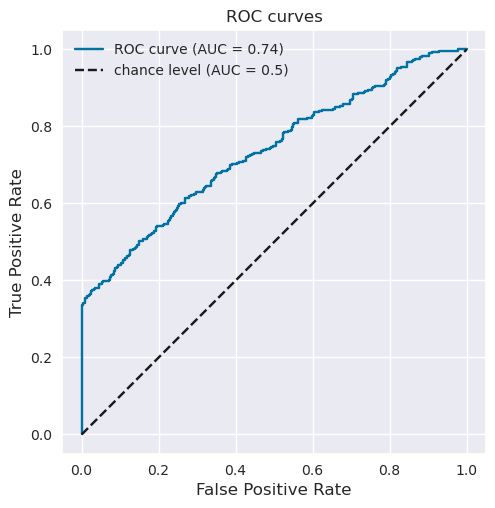

In [114]:
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend()
plt.show()